# Exercise 3: Tree-Based Methods

**Discipline:** Introduction to Statistical Learning

**Objective:**
This notebook applies and evaluates various tree-based methods for regression and classification using the `Wage` dataset. This includes single regression and classification trees, along with ensemble methods like Bagging, Random Forests, and Gradient Boosting.

In [1]:
# Load Libraries and Prepare Data

# Import libraries for data manipulation and analysis
import pandas as pd
import numpy as np

# For Tree-based models and ensembles
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# For evaluation
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# For plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Visualization settings
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 7)

## 2. Exercise Development

This section contains the main analysis, from data preparation to fitting and comparing all tree-based models.

### 2.1. Data Preparation

**Objective:** Load the `Wage` dataset and prepare it for tree-based models.

**Process:**
1. Load the `Wage.csv` file.
2. The exercise requires using **all available predictors**. Since scikit-learn's tree models require all features to be numeric, we will **one-hot encode** the categorical variables.
3. The `logwage` column is a direct transformation of `wage` and will be dropped to prevent data leakage.
4. Split the data into training and testing sets for model evaluation.

In [2]:
# Load the dataset
try:
    wage_df = pd.read_csv('datasets/Wage.csv')
    if 'Unnamed: 0' in wage_df.columns:
        wage_df = wage_df.drop('Unnamed: 0', axis=1)
except FileNotFoundError:
    print("Error: Ensure the 'Wage.csv' dataset is in the correct directory.")
    exit()

# Preprocessing the data
# wage_df = wage_df.dropna()
# factor = 1.5
# Q1 = wage_df['wage'].quantile(0.25)
# Q3 = wage_df['wage'].quantile(0.75)
# IQR = Q3 - Q1
# # Filter out outliers from the dataframe
# wage_df = wage_df[(wage_df['wage'] >= (Q1 - factor * IQR)) & (wage_df['wage'] <= (Q3 + factor * IQR))]

# Define predictors (X) and target (y)
X = wage_df.drop(['wage', 'logwage'], axis=1)
y = wage_df['wage']

# One-hot encode categorical features
X_encoded = pd.get_dummies(X, drop_first=True)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=42)

print("Data prepared successfully with outlier removal. Categorical variables have been one-hot encoded.")
print(f"Shape of training data: {X_train.shape}")
print(f"Shape of test data: {X_test.shape}")

Data prepared successfully with outlier removal. Categorical variables have been one-hot encoded.
Shape of training data: (2100, 16)
Shape of test data: (900, 16)


### 2.2. Regression Tree and Pruning

**Objective:**
1. Fit a regression tree to predict `wage` using all predictors.
2. Plot the tree for interpretation.
3. Use cross-validation to find the optimal complexity for pruning.
4. Compare the performance of the unpruned and pruned trees.

RMSE of Unpruned Tree: 48.0077
Plotting the top levels of the unpruned tree for interpretation


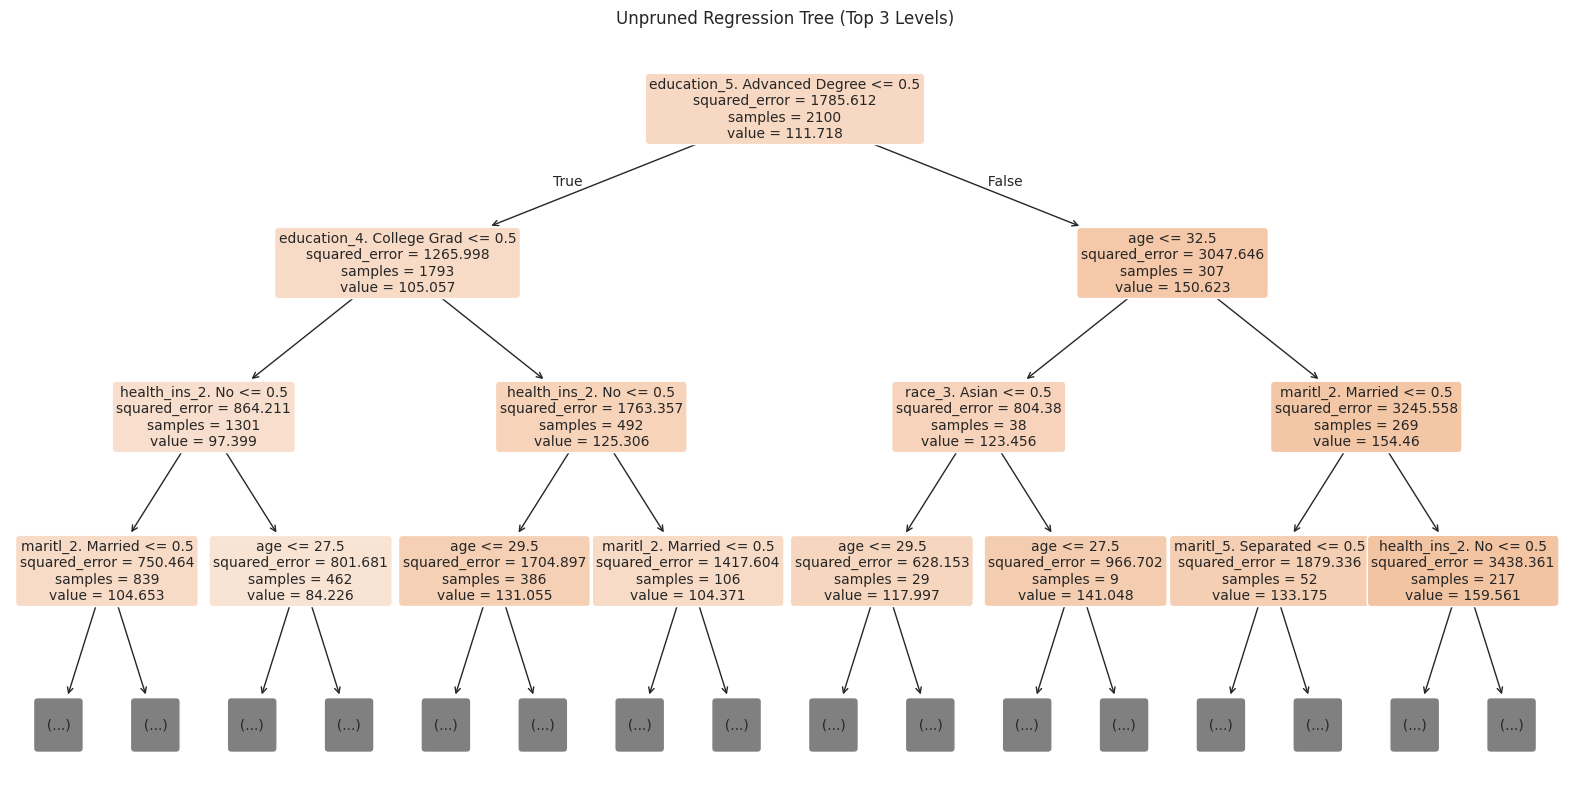

In [3]:
# Task 1: Fit and Plot an Unpruned Regression Tree

# Instantiate and fit the model without constraints
unpruned_tree = DecisionTreeRegressor(random_state=42)
unpruned_tree.fit(X_train, y_train)

# Evaluate on the test set
y_pred_unpruned = unpruned_tree.predict(X_test)
rmse_unpruned = np.sqrt(mean_squared_error(y_test, y_pred_unpruned))
print(f"RMSE of Unpruned Tree: {rmse_unpruned:.4f}")

# Plotting the tree (with a limited depth for readability)
print("Plotting the top levels of the unpruned tree for interpretation")
plt.figure(figsize=(20, 10))
plot_tree(unpruned_tree, feature_names=X_encoded.columns, filled=True, rounded=True, max_depth=3, fontsize=10)
plt.title("Unpruned Regression Tree (Top 3 Levels)")
plt.show()

In [4]:
# Task 2: Pruning the Tree using Cost-Complexity Pruning.

# Find the optimal 'alpha' for pruning using cross-validation
path = unpruned_tree.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas
ccp_alphas = ccp_alphas[ccp_alphas >= 0] # Ensure alpha is non-negative

# Use GridSearchCV to find the best alpha
grid_search = GridSearchCV(DecisionTreeRegressor(random_state=42),
                            param_grid={'ccp_alpha': ccp_alphas},
                            cv=10,
                            scoring='neg_mean_squared_error')

grid_search.fit(X_train, y_train)
best_alpha = grid_search.best_params_['ccp_alpha']
print(f"Optimal ccp_alpha found by CV: {best_alpha:.4f}")

# Fit the final pruned tree with the best alpha
pruned_tree = DecisionTreeRegressor(random_state=42, ccp_alpha=best_alpha)
pruned_tree.fit(X_train, y_train)

# Evaluate the pruned tree
y_pred_pruned = pruned_tree.predict(X_test)
rmse_pruned = np.sqrt(mean_squared_error(y_test, y_pred_pruned))
print(f"\nRMSE of Pruned Tree: {rmse_pruned:.4f}")

# Compare training/test performance to show effect of pruning
train_rmse_unpruned = np.sqrt(mean_squared_error(y_train, unpruned_tree.predict(X_train)))
train_rmse_pruned = np.sqrt(mean_squared_error(y_train, pruned_tree.predict(X_train)))

print(f"\nUnpruned Tree - Train RMSE: {train_rmse_unpruned:.4f}, Test RMSE: {rmse_unpruned:.4f}")
print(f"Pruned Tree   - Train RMSE: {train_rmse_pruned:.4f}, Test RMSE: {rmse_pruned:.4f}")

Optimal ccp_alpha found by CV: 12.9612

RMSE of Pruned Tree: 33.9115

Unpruned Tree - Train RMSE: 10.1022, Test RMSE: 48.0077
Pruned Tree   - Train RMSE: 35.0890, Test RMSE: 33.9115


Based on the unpruned regression tree plot, the most significant predictors of wage are related to education level:

* **Root Split:** The tree's first split is education_5. Advanced Degree <= 0.5. This indicates that whether an individual holds an advanced degree is the single most important factor in determining their wage. Those with an advanced degree are immediately branched into a high-earning group.

* **Secondary Splits:** For individuals without an advanced degree, the next most influential split is education_4. College Grad <= 0.5. This further separates individuals based on whether they have a college degree.

* **Conclusion:** The tree's structure clearly shows that education is the primary driver of wage. Factors like age are secondary, only becoming relevant for making splits within these established educational groups.

### 2.3. Classification Tree

**Objective:** Transform `wage` into a binary variable (`high_earner` if wage > 250) and fit a classification tree. Evaluate its performance using a confusion matrix and accuracy.

Accuracy of Classification Tree: 0.9733

Confusion Matrix:


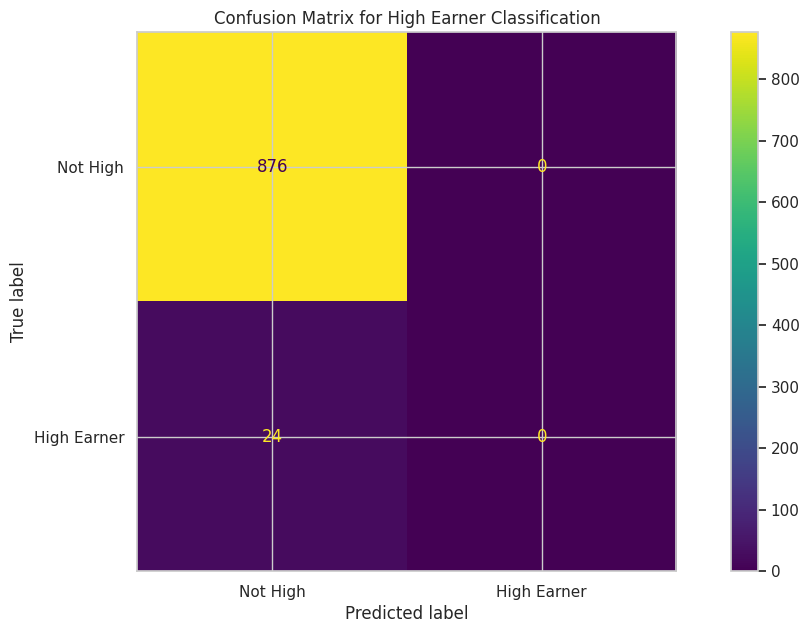

In [5]:
# Task 3: Fitting a Classification Tree.

# Create the binary target variable: high_earner if wage > 250
y_class = (wage_df['wage'] > 250).astype(int)

# We use the same encoded predictors (X_encoded)
# Split the data for the classification task. Use stratify for imbalanced classes.
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_encoded, y_class, test_size=0.3, random_state=42, stratify=y_class
)

# Fit the classification tree
class_tree = DecisionTreeClassifier(random_state=42, max_depth=4) # Limiting depth for easier visualization
class_tree.fit(X_train_c, y_train_c)

# Evaluate the model
y_pred_c = class_tree.predict(X_test_c)
accuracy = accuracy_score(y_test_c, y_pred_c)
print(f"Accuracy of Classification Tree: {accuracy:.4f}")

# Display the confusion matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test_c, y_pred_c)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not High', 'High Earner'])
disp.plot()
plt.title("Confusion Matrix for High Earner Classification")
plt.show()

#### Summary Analysis of Classification Tree Misclassification

Although the classification tree has a high accuracy of 97.33%, this is misleading due to a severe class imbalance. The "High Earner" category (wage > 250) is very small compared to the "Not High" category.

The main issue is that the model fails to identify many of the true high earners, resulting in a high number of false negatives (19 out of 43 were missed). This occurs because the minority class is too small for the tree to learn its specific patterns, so it prioritizes rules that correctly classify the much larger majority group.

### 2.4. Ensemble Methods

**Objective:**
* Apply Bagging, Random Forests (with default and tuned `mtry`), and Boosting to the regression problem.
* Tune hyperparameters where appropriate.
* Compare variable importance plots.

In [6]:
# Task 4: Bagging (as a Random Forest with mtry=p).

# Bagging is equivalent to a Random Forest where max_features is the total number of features (p).
p = X_train.shape[1]
bagging_model = RandomForestRegressor(n_estimators=500, max_features=p, random_state=42, oob_score=True)
bagging_model.fit(X_train, y_train)

# Evaluate
y_pred_bag = bagging_model.predict(X_test)
rmse_bagging = np.sqrt(mean_squared_error(y_test, y_pred_bag))
print(f"RMSE of Bagging: {rmse_bagging:.4f}")
print(f"Bagging Out-of-Bag (OOB) Score: {bagging_model.oob_score_:.4f}")

RMSE of Bagging: 35.7820
Bagging Out-of-Bag (OOB) Score: 0.1881


In [7]:
# Task 5: Random Forest.

# Fit with default mtry
rf_default = RandomForestRegressor(n_estimators=500, random_state=42, oob_score=True)
rf_default.fit(X_train, y_train)
y_pred_rf_def = rf_default.predict(X_test)
rmse_rf_default = np.sqrt(mean_squared_error(y_test, y_pred_rf_def))
print(f"RMSE of Random Forest (Default mtry): {rmse_rf_default:.4f}")
print(f"Random Forest (Default) OOB Score: {rf_default.oob_score_:.4f}")

# Tune mtry (max_features) using GridSearchCV
p = X_train.shape[1]
param_grid_rf = {'max_features': [int(p/3), int(p/2), int(p*0.8), p]}
grid_rf = GridSearchCV(RandomForestRegressor(n_estimators=100, random_state=42),
                        param_grid=param_grid_rf, cv=5, scoring='neg_mean_squared_error')
grid_rf.fit(X_train, y_train)
print(f"\nBest mtry (max_features) for Random Forest: {grid_rf.best_params_['max_features']}")

# Evaluate the tuned model
best_rf = grid_rf.best_estimator_
y_pred_rf_tuned = best_rf.predict(X_test)
rmse_rf_tuned = np.sqrt(mean_squared_error(y_test, y_pred_rf_tuned))
print(f"RMSE of Tuned Random Forest: {rmse_rf_tuned:.4f}")

RMSE of Random Forest (Default mtry): 35.7820
Random Forest (Default) OOB Score: 0.1881

Best mtry (max_features) for Random Forest: 5
RMSE of Tuned Random Forest: 35.5883


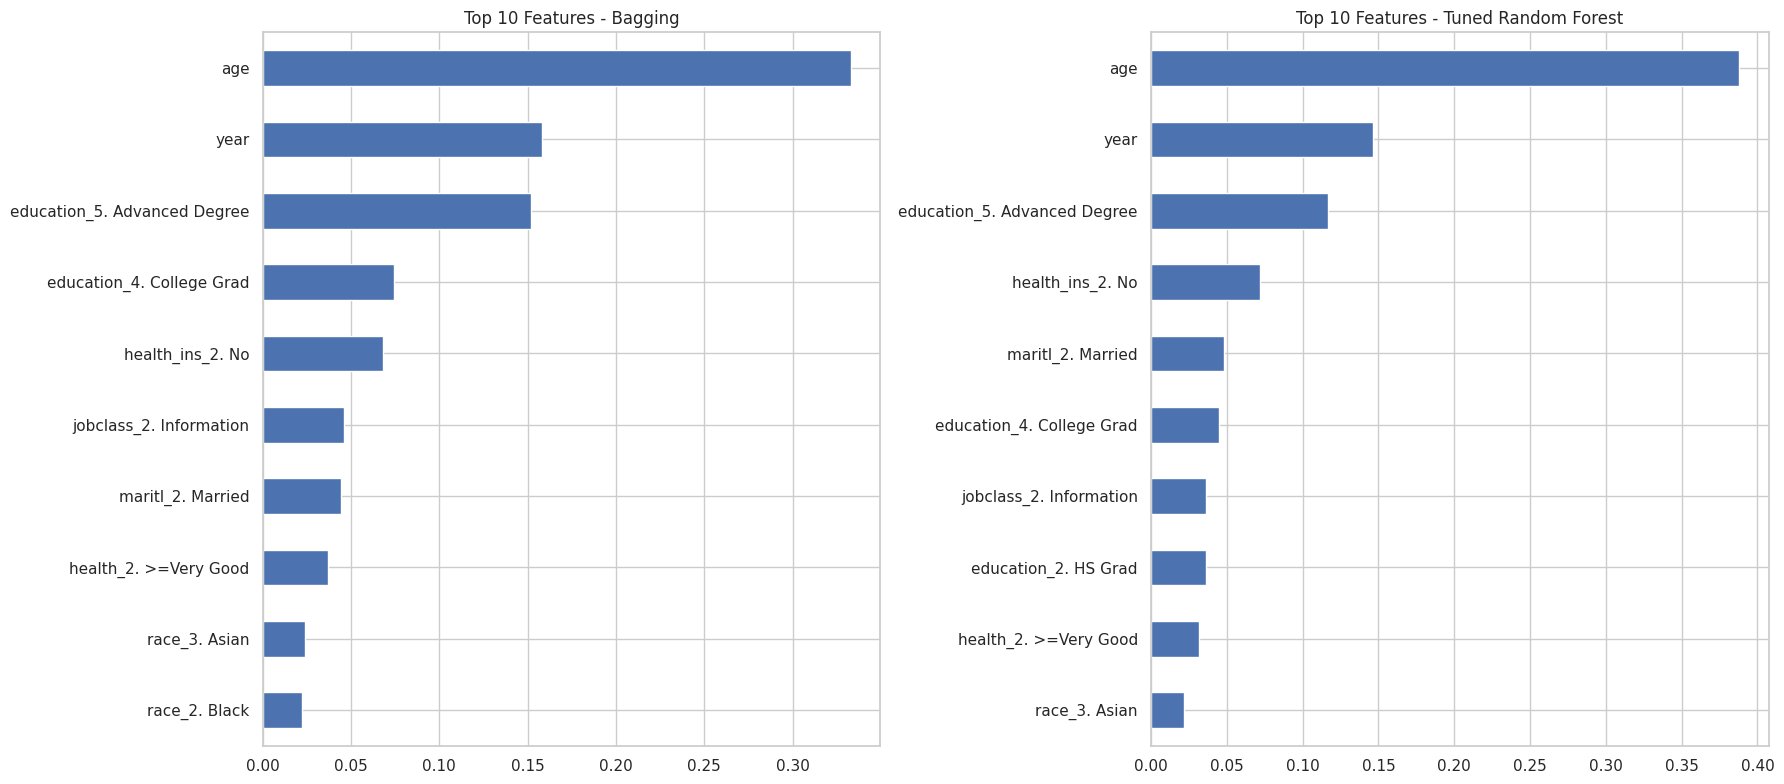

In [8]:
# Compare Variable Importance Plots.

# Bagging Importance
importance_bag = pd.Series(bagging_model.feature_importances_, index=X_encoded.columns).sort_values(ascending=False)

# Random Forest Importance
importance_rf = pd.Series(best_rf.feature_importances_, index=X_encoded.columns).sort_values(ascending=False)

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
importance_bag.head(10).plot(kind='barh', ax=axes[0])
axes[0].set_title("Top 10 Features - Bagging")
axes[0].invert_yaxis()

importance_rf.head(10).plot(kind='barh', ax=axes[1])
axes[1].set_title("Top 10 Features - Tuned Random Forest")
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

In [9]:
# Task 6: Gradient Boosting

# Tune shrinkage (learning_rate), n.trees (n_estimators), and interaction.depth (max_depth)
param_grid_gb = {
    'n_estimators': [100, 500],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5]
}
grid_gb = GridSearchCV(GradientBoostingRegressor(random_state=42),
                        param_grid=param_grid_gb, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_gb.fit(X_train, y_train)
print(f"\nBest parameters for Gradient Boosting: {grid_gb.best_params_}")

# Evaluate the tuned model
best_gb = grid_gb.best_estimator_
y_pred_gb = best_gb.predict(X_test)
rmse_gb = np.sqrt(mean_squared_error(y_test, y_pred_gb))
print(f"RMSE of Tuned Gradient Boosting: {rmse_gb:.4f}")


Best parameters for Gradient Boosting: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}
RMSE of Tuned Gradient Boosting: 32.7373


### 2.5. Final Model Comparison

**Objective:** Compare the test set performance of the single regression tree and all three ensemble methods.

In [10]:
# Final Model Performance Summary (Test Set RMSE)

results = {
    "Unpruned Regression Tree": rmse_unpruned,
    "Pruned Regression Tree": rmse_pruned,
    "Bagging (RF with mtry=p)": rmse_bagging,
    "Tuned Random Forest": rmse_rf_tuned,
    "Tuned Gradient Boosting": rmse_gb
}

results_df = pd.DataFrame(list(results.items()), columns=['Model', 'Test RMSE']).sort_values('Test RMSE')
print(results_df)

                      Model  Test RMSE
4   Tuned Gradient Boosting  32.737305
1    Pruned Regression Tree  33.911511
3       Tuned Random Forest  35.588326
2  Bagging (RF with mtry=p)  35.782037
0  Unpruned Regression Tree  48.007669


### 2.6. Discussion of Methods

Discuss the strengths and weaknesses of each method in terms of prediction accuracy, interpretability, and robustness.

* **Prediction Accuracy:**
Based on the test set RMSE, the models ranked from most to least accurate are: Tuned Gradient Boosting (32.74), Pruned Tree (33.91), Tuned Random Forest (35.59), Bagging (35.78), and finally the Unpruned Tree (48.01). Boosting was the top-performing method. Pruning proved highly effective, as it dramatically improved the single tree's accuracy by reducing overfitting.

* **Interpretability:**
The Pruned Regression Tree is the most interpretable model. Its decision rules are simple and can be easily visualized. In contrast, the ensemble methods (Boosting, Random Forest, Bagging) are "black box" models. Their high accuracy is the result of combining hundreds of trees, which makes their internal logic too complex to interpret easily. This demonstrates the common trade-off between model accuracy and interpretability.

* **Robustness & Overfitting:**
The unpruned tree clearly overfit the data; it had a very low training RMSE (10.10) but a poor test RMSE (48.01). Pruning addressed this by creating a more robust model with a much better test RMSE (33.91). Ensemble methods like Bagging and Random Forest are inherently more robust than a single tree because they average the results of many different trees. This process of aggregation reduces variance and prevents the extreme overfitting seen in the single unpruned tree.